# Seismic Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit #used for curve fitting
import random
import uncertainties as un
from uncertainties import unumpy

Text(0, 0.5, 'Arrival time (s)')

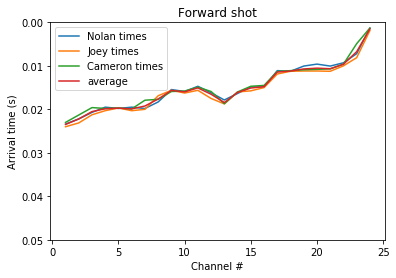

In [2]:
#The first step is to pick out wave arrival times from the forward data.
#I measured out the number of pixels from the axis to the wave start and
#then converted that to seconds.
my_times_f = np.flip(np.array([9,48,62,67,64,67,75,74,99,99,109,119,108,98,106,103,122,132,130,132,130,138,148,156])*0.00015)
#This is Joey's data
j_times_f = np.array([0.024,0.023125,0.02125,0.0203125,0.0196875,0.0203125,0.02,0.016875,0.015625,0.01625,0.015625,0.0175,0.01875,0.016,0.01575,0.015,0.011875,0.01125,0.0111875,0.0111875,0.01125,0.01,0.008125,0.001875])
#This is Cameron's data.
c_times_f = np.array([0.027,0.0253,0.0236,0.0238,0.0237,0.0239,0.0219,0.0217,0.0199,0.0198,0.0189,0.0199,0.0227,0.02,0.0187,0.0185,0.0153,0.0151,0.0149,0.0148,0.0147,0.0136,0.0089,0.0053,])-(0.004)

#These are the average forward arrival times and the standard deviations on that average.
avg_f = np.flip(np.mean([my_times_f,j_times_f,c_times_f],axis=0))
std_f = np.flip(np.std([my_times_f,j_times_f,c_times_f],axis=0))

#Here's an array that compiles the standard deviations and the arrival times for uncertainty propagation
avg_f_un = un.unumpy.uarray(avg_f,std_f)

#Here's a receiver array:
receivers = np.linspace(1,24,24)

plt.figure()
plt.plot(receivers,my_times_f,label='Nolan times')
plt.plot(receivers,(j_times_f),label='Joey times')
plt.plot(receivers,c_times_f,label='Cameron times')
plt.plot(receivers,np.flip(avg_f),label='average')
plt.legend(loc='best')
#plt.plot(receivers,avg_f)
plt.ylim(0,0.05)
plt.gca().invert_yaxis()
plt.title("Forward shot")
plt.xlabel("Channel #")
plt.ylabel("Arrival time (s)")

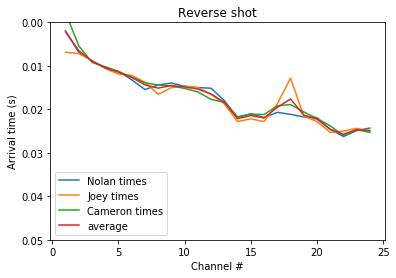

In [4]:
#Now we can load in the reverse shot data:
my_times_r = np.array([13,46,59,70,75,88,103,96,93,98,100,101,120,146,140,146,138,141,145,146,164,175,166,162])*0.00015
j_times_r = np.array([0.006875,0.0071875,0.00875,0.010625,0.011875,0.0121875,0.01375,0.0165625,0.015,0.0146875,0.015,0.0165625,0.01875,0.0228125,0.0221875,0.0228125,0.01875,0.0128125,0.0215625,0.0228125,0.0253125,0.025,0.024375,0.025,])
c_times_r = np.array([0.00178,0.0094,0.0132,0.0142,0.0153,0.0166,0.0179,0.0184,0.0186,0.0192,0.02,0.0217,0.0224,0.0257,0.0251,0.0252,0.0232,0.0229,0.0246,0.0261,0.0278,0.03,0.0287,0.0293,])-(1/2)*(0.008)

#And get the averages and standard deviations
avg_r = np.flip(np.mean([my_times_r,j_times_r,c_times_r],axis=0))
std_r = np.flip(np.std([my_times_r,j_times_r,c_times_r],axis=0))
avg_r_un = un.unumpy.uarray(avg_r,std_r)
receivers = np.linspace(1,24,24)

plt.figure()
plt.plot(receivers,my_times_r,label='Nolan times')
plt.plot(receivers,j_times_r,label='Joey times')
plt.plot(receivers,c_times_r,label='Cameron times')
plt.plot(receivers,np.flip(avg_r),label='average')
plt.legend(loc='best')
plt.ylim(0,0.05)
plt.title("Reverse shot")
plt.xlabel("Channel #")
plt.ylabel("Arrival time (s)")
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'Forward and Reverse shot arrival times')

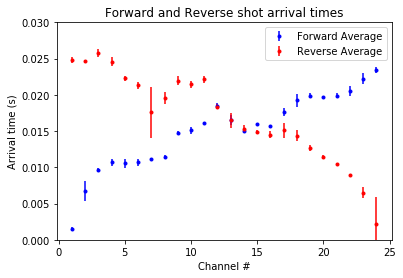

In [6]:
#Let's visualize the uncertainties of the forward and reverse shots here:
plt.figure()
plt.errorbar(receivers,avg_f,yerr=std_f,fmt='.b',label='Forward Average')
plt.errorbar(receivers,avg_r,yerr=std_r,fmt='.r',label='Reverse Average')
plt.ylim(0,0.03)
plt.legend(loc='best')
plt.xlabel("Channel #")
plt.ylabel("Arrival time (s)")
plt.title("Forward and Reverse shot arrival times")

In [16]:
#Now we can start doing some velocity calculations.
#Let's initialize our distance array and our forward and reverse arrival times (with uncertainties)
x = np.linspace(1,47,24)
f_un = avg_f_un
r_un = np.flip(avg_r_un)

#Quickly get estimates for v1 from both forward and reverse directions
v1_f = (x[1])/(f_un[1])
v1_r = (x[1])/(r_un[1])
#And average those two estimates:
v1_avg = np.mean([v1_f,v1_r])
print("Average: ",v1_avg," v1_f: ", v1_f," v1_r: ",v1_r)
v1_avg_nom = v1_avg.n
v1_avg_std = v1_avg.s

Average:  (4.5+/-0.5)e+02  v1_f:  (4.4+/-0.9)e+02  v1_r:  (4.6+/-0.6)e+02


In [18]:
#Now we can use the time delay method to get v2 and the undulations topography!
#Here are our main two functions:
hg_func = lambda Tg,v1,v2: Tg*(v1*v2)/((v2**2 - v1**2)**(1/2))
Tg_func = lambda tefg,terg,tr: (tefg + terg - tr)/2

f = f_un
r = r_un

tr = (f[-1]+r[-1])/2 #reciprocal time
#Our single-arrival data points:
tefg = f[1:-1]
terg = np.flip(r[1:-1])
#get the differences of these data points
tdiff = tefg-terg
xdiff = x[1:-1]

#Let's get v2:
v2 = 2/((tdiff[-1]-tdiff[0])/(xdiff[-1]-xdiff[0]))
print("v2: ",v2)

#Let's get Tg:
Tg = Tg_func(tefg,terg,tr)
hg = hg_func(Tg,v1_avg,v2)
#Now let's break apart our H_g value into its nominal and error parts
#This will be used in plotting up the circles.
hg_nominal = []
hg_std = []
for i in range(len(hg)):
    hg_nominal.append(hg[i].n)
    hg_std.append(hg[i].s)

v2:  (2.50+/-0.13)e+03


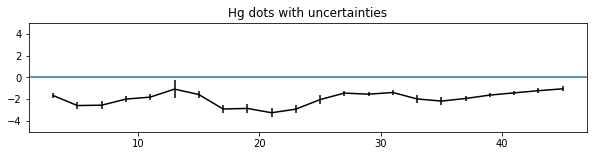

In [20]:
#Now we can do an initial plot of our undulation surface!
plt.figure(figsize=[10,2])
plt.title('Hg dots with uncertainties')
plt.errorbar(x[1:-1],-np.array(hg_nominal),hg_std,fmt='k')
plt.xlim((1,max(x)))

plt.ylim((-5,5))
plt.axhline(0)
plt.show()

v2, not accounting for uncertainties:  2497.8317432784042


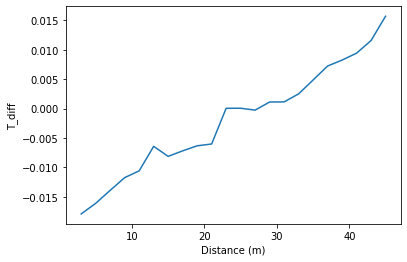

In [24]:
#Let's redo this calculation to get a plot of our t_diff values. We have to redo it here WITHOUT uncertainties
#to get this plot.
f = avg_f
r = np.flip(avg_r)
x = np.linspace(1,47,24)

tr = (f[-1]+r[-1])/2 #reciprocal time
tefg = f[1:-1]
terg = np.flip(r[1:-1])
tdiff = tefg-terg
xdiff = x[1:-1]
plt.figure()
plt.plot(xdiff,tdiff)
plt.xlabel("Distance (m)")
plt.ylabel("T_diff")

#Just to double check our previous answer (with uncertainties), let's get v2:
v2 = 2/((tdiff[-1]-tdiff[0])/(xdiff[-1]-xdiff[0]))
print("v2, not accounting for uncertainties: ",v2)

#Let's get Tg:
Tg = Tg_func(tefg,terg,tr)
hg = hg_func(Tg,v1_avg_nom,v2)

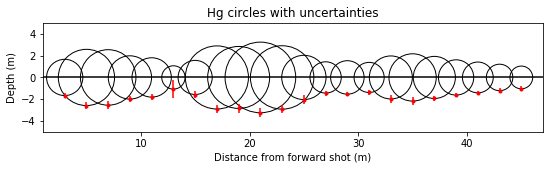

In [25]:
#Now we can get a more complex plot of our h_g undulation radii with uncertainties.
figure, axes = plt.subplots()
figure.set_figheight(2)
figure.set_figwidth(10)
draw_circle = []
for i in range(0,len(xdiff)):
    draw_circle.append(plt.Circle((xdiff[i], 0), hg[i],fill=False))
    axes.add_artist(draw_circle[i])

axes.set_aspect(1)
plt.title('Hg circles with uncertainties')
plt.errorbar(x[1:-1],-np.array(hg_nominal),hg_std,fmt='.r')
plt.xlim((1,max(x)))
plt.ylim((-5,5))
plt.axhline(0,color='k')
plt.xlabel("Distance from forward shot (m)")
plt.ylabel("Depth (m)")
plt.show()

In [26]:
#Finally, let's get an average thickness of the first layer.
avg_thickness = np.mean(hg)
print(avg_thickness)

1.9526227697390846
